残差网络
===

# 1.传统网络的问题
传统的神经网络中，随着网络层数的增加，网络发生了退化(degradation)的现象：随着网络层数的增多，训练集loss逐渐下降，然后趋于饱和，当你再增加网络深度的话，训练集loss反而会增大。

注意这并不是过拟合，因为在过拟合中训练loss是一直减小的。当网络退化时，浅层网络能够达到比深层网络更好的训练效果，这时如果我们把低层的特征传到高层，那么效果应该至少不比浅层的网络效果差，

或者说如果一个VGG-100网络在第98层使用的是和VGG-16第14层一模一样的特征，那么VGG-100的效果应该会和VGG-16的效果相同。

所以，我们可以在VGG-100的98层和14层之间添加一条直接映射(Identity Mapping)来达到此效果。基于这种使用直接映射来连接网络不同层直接的思想，残差网络应运而生

# 2.残差网络
## 2.1.残差块
残差网络是由一系列残差块组成的（图1）。一个残差块可以用表示为：
$$x_{l+1}= x_l+\mathcal{F}(x_l, {W_l})$$
残差块分成两部分直接映射部分和残差部分。$h(x_l)$是直接映射，反应在图1中是左边的曲线；$\mathcal{F}(x_l, {W_l})$是残差部分，一般由两个或者三个卷积操作构成，即图1中右侧包含卷积的部分。
![image](Images/03/01/04_001.png)
图中的'Weight‘在卷积网络中是指卷积操作，’addition‘是指单位加操作。在卷积网络中，$x_l$可能和$x_{l+1}$的Feature Map的数量不一样，这时候就需要使用$1 \times 1$卷积进行升维或者降维。这时，残差块表示为：
$$x_{l+1}= h(x_l)+\mathcal{F}(x_l, {W_l})$$
![image](Images/03/01/04_002.png)
其中$h(x_l) = W'_lx$。其中$W'_l$是$1 \times 1$卷核，是实验结果$1 \times 1$卷积对模型性能提升有限，所以一般是在升维或者降维时才会使用。一般，这种版本的残差块叫做resnet_v1

In [1]:
import torch


class Res_Block_V1(torch.nn.Module):
    def __init__(self, input_filter, output_filter):
        super(Res_Block_V1, self).__init__()
        self.input_filter = input_filter
        self.output_filter = output_filter
        
        self.conv1 = torch.nn.Conv2d(in_channels=input_filter, out_channels=output_filter, kernel_size=3, stride=1)
        self.norm1 = torch.nn.BatchNorm2d(num_features=output_filter)
        self.conv2 = torch.nn.Conv2d(in_channels=output_filter, out_channels=output_filter, kernel_size=3, stride=1)
        self.norm2 = torch.nn.BatchNorm2d(num_features=output_filter)
        self.relu  = torch.nn.ReLU()
        
        self.otherConv = torch.nn.Conv2d(in_channels=output_filter, out_channels=output_filter, kernel_size=1, stride=1)
        
    def forward(self, input):
        x = self.conv1(input)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        
        if self.input_filter == self.output_filter:
            identity = input
        else:
            identity = self.otherConv(x)
        
        x += identity
        x = self.relu(x)
        return x

## 2.2.残差网络
残差网络的搭建分为两步：
- 使用VGG公式搭建Plain VGG网络
- 在Plain VGG的卷积网络之间插入Identity Mapping，注意需要升维或者降维的时候加入$1 \times 1$卷积。

在实现过程中，一般是直接stack残差块的方式。

In [2]:
class Resnet(torch.nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.linear_infeature = 64
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, stride=1, kernel_size=3)
        self.relu = torch.nn.ReLU()
        self.block1 = Res_Block_V1(16, 16)
        self.block2 = Res_Block_V1(16, 32)
        self.fc = torch.nn.Linear(in_features=self.linear_infeature, out_features=10)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, input):
        x = self.conv1(input)
        x = self.block1(x)
        x = self.block2(x)
        x = x.view(-1, self.linear_infeature)
        x = self.fc(x)
        x = self.softmax(x)
        
        return x

## 2.3.为什么叫做残差网络
在统计学中，残差和误差是非常容易混淆的两个概念。
- 误差是衡量观测值和真实值之间的差距
- 残差是指预测值和观测值之间的差距

网络的一层通常可以看做$y=H(x)$, 而残差网络的一个残差块可以表示为$H(x)=F(x)+x$，也就是$F(x) = H(x)-x$，在单位映射中，$y=x$便是观测值，

而$H(x)$是预测值，所以$F(x)$便对应着残差，因此叫做残差网络。

## 2.4.Resnet V2版本
经过试验之后发现，激活函数移动到残差部分可以提高模型的精度

In [ ]:
import torch


class Res_Block_V2(torch.nn.Module):
    def __init__(self, input_filter, output_filter):
        super(Res_Block_V1, self).__init__()
        self.input_filter = input_filter
        self.output_filter = output_filter
        
        self.norm0 = torch.nn.BatchNorm2d(num_features=input_filter)
        self.relu  = torch.nn.ReLU()
        
        self.conv1 = torch.nn.Conv2d(in_channels=input_filter, out_channels=output_filter, kernel_size=3, stride=1)
        self.norm1 = torch.nn.BatchNorm2d(num_features=output_filter)
        
        self.conv2 = torch.nn.Conv2d(in_channels=output_filter, out_channels=output_filter, kernel_size=3, stride=1)
        
        
        
        self.otherConv = torch.nn.Conv2d(in_channels=output_filter, out_channels=output_filter, kernel_size=1, stride=1)
        
    def forward(self, input):
        x = self.norm0(input)
        x = self.relu(x)
        
        x = self.conv1(input)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        
        if self.input_filter == self.output_filter:
            identity = input
        else:
            identity = self.otherConv(x)
        
        x += identity
        x = self.relu(x)
        return x


class Resnet_V2(torch.nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.linear_infeature = 64
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, stride=1, kernel_size=3)
        self.relu = torch.nn.ReLU()
        self.block1 = Res_Block_V2(16, 16)
        self.block2 = Res_Block_V2(16, 32)
        self.norm1 = torch.nn.BatchNorm2d(num_features=32)
        self.fc = torch.nn.Linear(in_features=self.linear_infeature, out_features=10)
        self.softmax = torch.nn.Softmax()
        
    def forward(self, input):
        x = self.conv1(input)
        x = self.block1(x)
        x = self.block2(x)
        x = self.norm1(x)
        x = x.view(-1, self.linear_infeature)
        x = self.fc(x)
        x = self.softmax(x)
        
        return x

## 2.5.网络结构

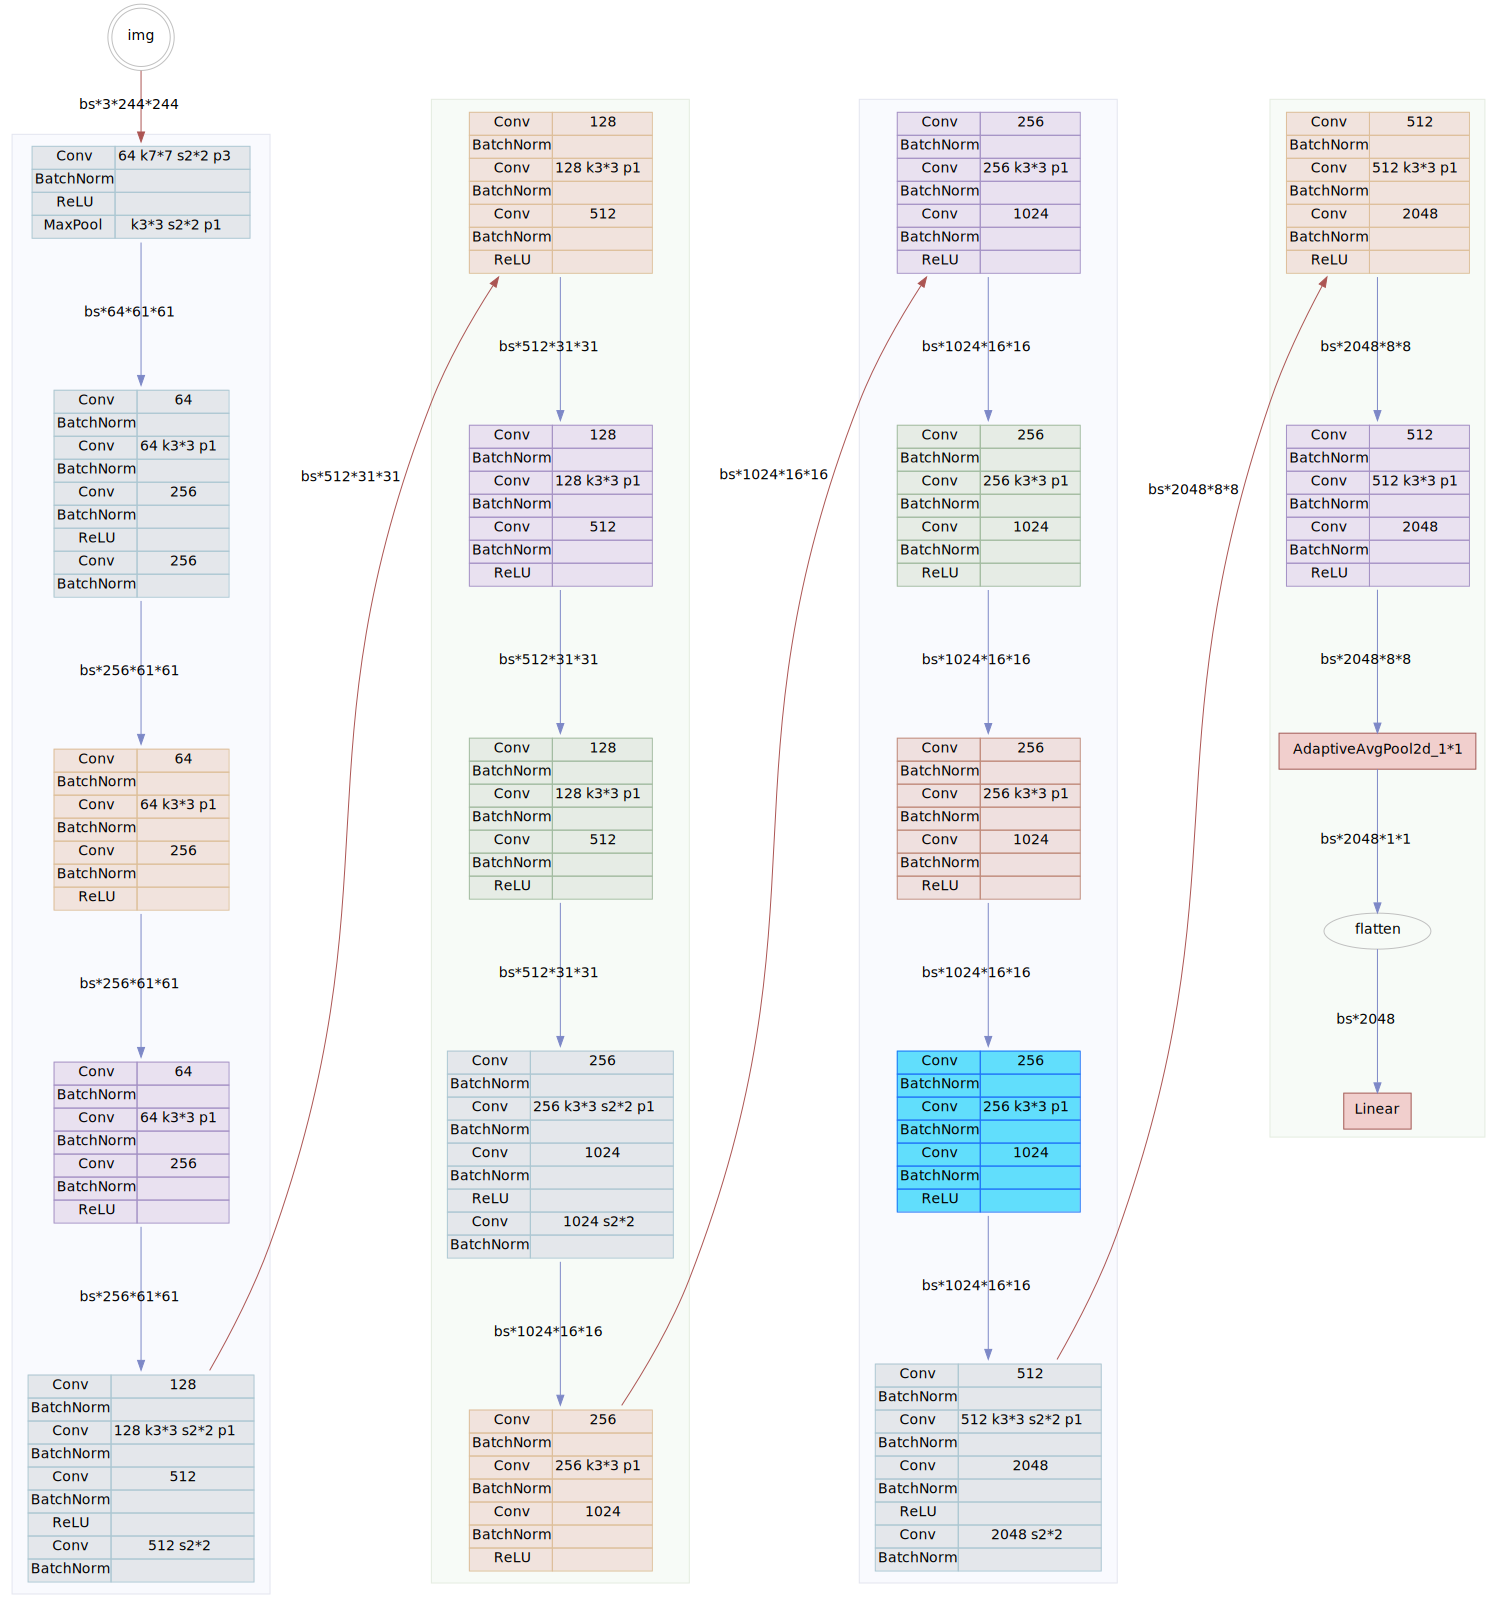

In [1]:
import graphviz

FONT_NAME = "Fira Code Retina"
graph = graphviz.Digraph(name="ResNet50", format='png',node_attr={'shape': 'plaintext'}, edge_attr = {"constraint":"false"})
graph.attr(nodesep="0.5", rankdir="LR")

with graph.subgraph(name="cluster_1") as sub1:
    sub1.attr(bgcolor="#F9FAFE", color="#E3E5EF")
    with graph.subgraph() as s:
        s.node("block1", '''<
            <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
            <tr><td>Conv</td><td>64 k7*7 s2*2 p3</td></tr>
            <tr><td>BatchNorm</td><td></td></tr>
            <tr><td>ReLU</td><td></td></tr>
            <tr><td>MaxPool</td><td>k3*3 s2*2 p1</td></tr>
            </table>
            >''', fontname=FONT_NAME)
        s.node('block2', '''<
                <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                <tr><td>Conv</td><td>64</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>Conv</td><td>64 k3*3 p1</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>Conv</td><td>256</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                <tr><td>ReLU</td><td></td></tr>
                <tr><td>Conv</td><td>256</td></tr>
                <tr><td>BatchNorm</td><td></td></tr>
                </table>
                >''', fontname=FONT_NAME)
        s.node('block3', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                    <tr><td>Conv</td><td>64</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>64 k3*3 p1</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>256</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block4', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                    <tr><td>Conv</td><td>64</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>64 k3*3 p1</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>256</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block5', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>128 k3*3 s2*2 p1</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>512</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>512 s2*2</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
    sub1.edge("block1", "block2", label="bs*64*61*61", color="#7D88C7", fontname=FONT_NAME)
    sub1.edge("block2", "block3", color="#7D88C7", label="bs*256*61*61", fontname=FONT_NAME)
    sub1.edge("block3", "block4", color="#7D88C7", label="bs*256*61*61", fontname=FONT_NAME)
    sub1.edge("block4", "block5", label="bs*256*61*61", color="#7D88C7", fontname=FONT_NAME)

graph.node('img', shape="doublecircle", color="grey", fontname=FONT_NAME)
graph.edge("img", "block1", label="bs*3*244*244", color="#AC5553", fontname=FONT_NAME)


with graph.subgraph(name="cluster_2") as sub2:
    sub2.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block6', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>128 k3*3 p1</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>512</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block7', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>128 k3*3 p1</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>512</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block8', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                    <tr><td>Conv</td><td>128</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>128 k3*3 p1</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>512</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block9', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>Conv</td><td>256</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>256 k3*3 s2*2 p1</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>1024</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>1024 s2*2</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block10', '''<
                        <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                        <tr><td>Conv</td><td>256</td></tr>
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>Conv</td><td>256 k3*3 p1</td></tr>
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>Conv</td><td>1024</td></tr>
                        <tr><td>BatchNorm</td><td></td></tr>
                        <tr><td>ReLU</td><td></td></tr>
                        </table>
                        >''', fontname=FONT_NAME)

    sub2.edge("block6", "block7", color="#7D88C7", label="bs*512*31*31", fontname=FONT_NAME)
    sub2.edge("block7", "block8", color="#7D88C7", label="bs*512*31*31", fontname=FONT_NAME)
    sub2.edge("block8", "block9", color="#7D88C7", label="bs*512*31*31", fontname=FONT_NAME)
    sub2.edge("block9", "block10", color="#7D88C7", label="bs*1024*16*16", fontname=FONT_NAME)

graph.node("T0", style="invis")
graph.edge("block1", "T0", constraint="true", style="invis")
graph.edge("T0", "block6", constraint="true", style="invis")

graph.edge("block5", "block6", color="#AC5553", label="bs*512*31*31", fontname=FONT_NAME)

with graph.subgraph(name="cluster_3") as sub3:
    sub3.attr(color="#E3E5EF", bgcolor="#F9FAFE")
    with graph.subgraph() as s:
        s.node('block11', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                    <tr><td>Conv</td><td>256</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>256 k3*3 p1</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>1024</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block12', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E6ECE5" color="#A2BBA0">
                    <tr><td>Conv</td><td>256</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>256 k3*3 p1</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>1024</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block13', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#EFE0DF" color="#C08B7B">
                    <tr><td>Conv</td><td>256</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>256 k3*3 p1</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>1024</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block14', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#61DEFC" color="#2075F8">
                    <tr><td>Conv</td><td>256</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>256 k3*3 p1</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>1024</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block15', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E4E7EB" color="#ACC7D2">
                    <tr><td>Conv</td><td>512</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>512 k3*3 s2*2 p1</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>2048</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    <tr><td>Conv</td><td>2048 s2*2</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)

    sub3.edge("block11", "block12", color="#7D88C7", label="bs*1024*16*16", fontname=FONT_NAME)
    sub3.edge("block12", "block13", color="#7D88C7", label="bs*1024*16*16", fontname=FONT_NAME)
    sub3.edge("block13", "block14", color="#7D88C7", label="bs*1024*16*16", fontname=FONT_NAME)
    sub3.edge("block14", "block15", color="#7D88C7", label="bs*1024*16*16", fontname=FONT_NAME)

graph.node("T1", style="invis")
graph.edge("block6", "T1", constraint="true", style="invis")
graph.edge("T1", "block11", constraint="true", style="invis")
graph.edge("block10", "block11", color="#AC5553", label="bs*1024*16*16", fontname=FONT_NAME)

with graph.subgraph(name="cluster_4") as sub4:
    sub4.attr(color="#E4ECE0", bgcolor="#F7FBF7")
    with graph.subgraph() as s:
        s.node('block16', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#F1E3DD" color="#DDBF9A">
                    <tr><td>Conv</td><td>512</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>512 k3*3 p1</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>2048</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node('block17', '''<
                    <table border="0" CELLBORDER="1" CELLSPACING="0" bgcolor="#E9E1F0" color="#A592C5">
                    <tr><td>Conv</td><td>512</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>512 k3*3 p1</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>Conv</td><td>2048</td></tr>
                    <tr><td>BatchNorm</td><td></td></tr>
                    <tr><td>ReLU</td><td></td></tr>
                    </table>
                    >''', fontname=FONT_NAME)
        s.node("block18", shape="box", color="#A25954", style="filled", fillcolor="#F1CFCD", label="AdaptiveAvgPool2d_1*1", fontname=FONT_NAME)
        s.node("block19", shape="ellipse", color="grey", label="flatten", fontname=FONT_NAME)
        s.node("block20", shape="box", color="#A25954", style="filled", fillcolor="#F1CFCD", label="Linear", fontname=FONT_NAME)

    sub4.edge("block16", "block17", color="#7D88C7", label="bs*2048*8*8", fontname=FONT_NAME)
    sub4.edge("block17", "block18", color="#7D88C7", label="bs*2048*8*8", fontname=FONT_NAME)
    sub4.edge("block18", "block19", color="#7D88C7", label="bs*2048*1*1", fontname=FONT_NAME)
    sub4.edge("block19", "block20", color="#7D88C7", label="bs*2048", fontname=FONT_NAME)

graph.node("T2", style="invis")
graph.edge("block11", "T2", constraint="true", style="invis")
graph.edge("T2", "block16", constraint="true", style="invis")
graph.edge("block15", "block16", color="#AC5553", label="bs*2048*8*8", fontname=FONT_NAME)

graph